In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('/Users/jeremiahwilson/Downloads/pitch_data_one_month.csv')

In [13]:
#dropping old index column
data = data.drop('Unnamed: 0', axis = 1)

In [17]:
data.columns

Index(['GAME_ID', 'PA_IN_GAME', 'PITCH_IN_PA', 'CATCHER_ID', 'PITCHER_ID',
       'BATTER_ID', 'UMPIRE_ID', 'BALLPARK_ID', 'BALLS', 'STRIKES', 'OUTS',
       'INNING', 'INNING_HALF', 'AWAY_TEAM_SCORE', 'HOME_TEAM_SCORE',
       'RUNNER_ON_1B', 'RUNNER_ON_2B', 'RUNNER_ON_3B', 'PITCH_RESULT',
       'EVENT_RESULT', 'BATTER_SIDE', 'PITCHER_SIDE', 'PITCH_TYPE',
       'PITCH_SPEED', 'PITCH_LOCATION_SIDE', 'PITCH_LOCATION_HEIGHT',
       'STRIKE_ZONE_TOP', 'STRIKE_ZONE_BOTTOM', 'SPIN_RATE',
       'INDUCED_VERTICAL_BREAK', 'HORIZONTAL_BREAK', 'VERTICAL_APPROACH_ANGLE',
       'HORIZONTAL_APPROACH_ANGLE', 'RELEASE_SIDE', 'RELEASE_HEIGHT',
       'RELEASE_EXTENSION', 'EXIT_VELOCITY', 'LAUNCH_ANGLE', 'SPRAY_ANGLE'],
      dtype='object')

In [21]:
data['PITCH_RESULT'].unique()

array(['InPlay', 'StrikeSwinging', 'BallCalled', 'FoulBall',
       'StrikeCalled', 'HitByPitch', nan, 'Undefined'], dtype=object)

In [22]:
#getting all the relevant pitches that were called strikes or balls
relevant_data = data.loc[data['PITCH_RESULT'].isin(['BallCalled', 'StrikeCalled'])]

In [25]:
relevant_data.shape

(65925, 39)

In [28]:
#making column to denote numerical values for pitch result. 0 for ball, 1 for strike
relevant_data['OUTCOME'] = 0
relevant_data.loc[relevant_data['PITCH_RESULT'] == 'StrikeCalled', 'OUTCOME'] = 1

/Users/jeremiahwilson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [32]:
#checking to see if any rows have missing pitch location data
relevant_data['PITCH_LOCATION_SIDE'].isna().sum()

202

In [33]:
relevant_data['PITCH_LOCATION_HEIGHT'].isna().sum()

202

In [37]:
#getting dataframe without missing pitch location data
relevant_data2 = relevant_data.loc[relevant_data['PITCH_LOCATION_HEIGHT'].notnull() & relevant_data['PITCH_LOCATION_SIDE'].notnull()]

In [44]:
#making a list of the column names of the columns that will be needed for the model
columns = ['OUTCOME', 'UMPIRE_ID', 'BALLS', 'STRIKES', 'BATTER_SIDE', 'PITCHER_SIDE', 'PITCH_SPEED','PITCH_LOCATION_SIDE','PITCH_LOCATION_HEIGHT','STRIKE_ZONE_TOP','STRIKE_ZONE_BOTTOM','INDUCED_VERTICAL_BREAK','HORIZONTAL_BREAK']

In [69]:
#getting a dataframe with only relevant columns
model_data = relevant_data2[columns]

In [70]:
model_data.shape

(65723, 13)

In [71]:
#dropping any remaining rows with missing values
model_data = model_data.dropna(axis = 0)

In [72]:
#one row was removed
model_data.shape

(65722, 13)

In [73]:
#making the umpire ID column categorical
model_data['UMPIRE_ID'] = model_data['UMPIRE_ID'].astype('category')

In [74]:
#one hot encoding our categorical variables to prepare for model training
one_hot_bside = pd.get_dummies(model_data['BATTER_SIDE'], prefix = 'BATS_')
one_hot_pside = pd.get_dummies(model_data['PITCHER_SIDE'], prefix = 'PITCHES_')
one_hot_umpID = pd.get_dummies(model_data['UMPIRE_ID'], prefix = 'UMP_')

In [75]:
#dropping old categorical columns
model_data = model_data.drop(['BATTER_SIDE', 'PITCHER_SIDE','UMPIRE_ID'], axis = 1)

In [76]:
#joining with our new one hot encoded columns
final_df = model_data.join([one_hot_bside, one_hot_pside, one_hot_umpID])

In [83]:
#separating features and outcome variable
x = final_df.drop('OUTCOME', axis = 1).values
y = final_df['OUTCOME']

In [84]:
y = y.astype(int)

In [89]:
#getting our ML libraries
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [90]:
#using kfold method for model training
folds = KFold(n_splits = 10, shuffle = True)

In [91]:
#initializing our model
import lightgbm as lgb
clf = lgb.LGBMClassifier()

In [92]:
result = cross_val_score(clf, x, y, cv = folds)

In [94]:
#checking out the average model performance with 10 folds
result.mean()

0.9307842356440924

In [129]:
#trying some hyperparameter tuning
clf2 = lgb.LGBMClassifier(boosting_type='gbdt',
    objective = 'binary',
    learning_rate = 0.09,
    max_depth = 6,
    num_leaves = 25,
    n_estimators = 195)

In [130]:
result2 = cross_val_score(clf2, x, y, cv = folds)

In [131]:
#slightly better accuracy with this model
result2.mean()

0.9312864029325969

In [133]:
#splitting our test and training data
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state = 0)

In [135]:
#training our model
clf2.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.09, max_depth=6,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=195, n_jobs=-1, num_leaves=25, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [149]:
#predicting
y_pred=clf2.predict(X_test)

In [150]:
#getting our accuracy
accuracy = metrics.accuracy_score(y_pred, y_test)

In [151]:
accuracy

0.9301635602890833

In [152]:
#predicting the training data
y_pred_train = clf2.predict(X_train)

In [153]:
print('Training set score: {:.4f}'.format(clf2.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf2.score(X_test, y_test)))

Training set score: 0.9439
Test set score: 0.9302


In [154]:
#getting confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n',cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[8504  472]
 [ 446 3723]]

True Positives(TP) =  8504

True Negatives(TN) =  3723

False Positives(FP) =  472

False Negatives(FN) =  446


In [193]:
#getting precision, recall and other performance metrics
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      8976
           1       0.89      0.89      0.89      4169

    accuracy                           0.93     13145
   macro avg       0.92      0.92      0.92     13145
weighted avg       0.93      0.93      0.93     13145



In [194]:
#predicting whole dataset now
whole_pred = clf2.predict(x)

In [195]:
#getting predicted probabilities into dataframe
pred_prob_df = pd.DataFrame(data = clf2.predict_proba(x), columns = ['ball_probablility',
                                                                       'strike_probability'])

In [196]:
#getting called strike probability into our df
final_df['CS_PROB'] = pred_prob_df['strike_probability']

In [197]:
#getting called strike probability into our df
final_df.reset_index(drop=True, inplace=True)
final_df['CS_PROB'] = pred_prob_df['strike_probability']

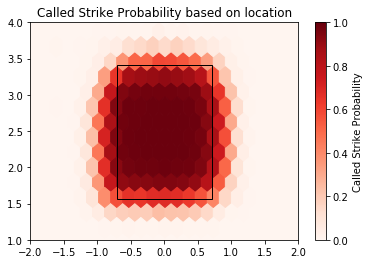

In [202]:
#creating a hexbin plot that shows how called strike probability changes based on pitch location
import matplotlib.patches as patches

#getting average measurements for top of strikezone and bottom of strikezone
sz_top = final_df['STRIKE_ZONE_TOP'].mean()
sz_bot = final_df['STRIKE_ZONE_BOTTOM'].mean()

#creating strikezone patch
strikezone = patches.Rectangle((-0.70833,sz_bot), width= 17/12, height = (sz_top-sz_bot), fill=False)

fig, ax = plt.subplots()
graph = ax.hexbin(final_df['PITCH_LOCATION_SIDE'],final_df['PITCH_LOCATION_HEIGHT'], C =final_df['CS_PROB'], 
              gridsize=(50), vmax = 1,vmin =0, cmap = 'Reds')
ax.add_patch(strikezone)
plt.xlim([-2,2])
plt.ylim([1,4])
ax.set_title('Called Strike Probability based on location')
cbar = fig.colorbar(graph)
cbar.set_label('Called Strike Probability')

In [204]:
relevant_data2 = relevant_data2.loc[relevant_data2['INDUCED_VERTICAL_BREAK'].notnull()]

In [205]:
relevant_data2.shape

(65722, 40)

In [208]:
relevant_data2.reset_index(drop=True,inplace=True)

In [209]:
relevant_data2['CS_PROB'] = final_df['CS_PROB']

In [216]:
#making a new column that gives the expected call of ball or strike, 0 for ball, 1 for strike
#if called strike probability is less than 0.5 we set the expected call to be 0. Otherwise it is 1
relevant_data2['EXPECTED_CALL'] = 1
relevant_data2.loc[relevant_data2['CS_PROB'] < 0.5, 'EXPECTED_CALL'] = 0

In [220]:
#getting a dataframe sorted by pitcher ID to compare the actual outcomes versus expected outcome
actual_vs_exp = relevant_data2.groupby('PITCHER_ID').sum()[['OUTCOME','EXPECTED_CALL']]

In [221]:
#making a column of how many calls a given pitcher lost
actual_vs_exp['CALLS_LOST'] = actual_vs_exp['EXPECTED_CALL'] - actual_vs_exp['OUTCOME']

In [226]:
#sorting by most lost calls
ranked_pitchers = actual_vs_exp.sort_values('CALLS_LOST', ascending = False)

In [227]:
#top ten pitchers with most strikes lost
ranked_pitchers[0:10]

,OUTCOME,EXPECTED_CALL,CALLS_LOST
PITCHER_ID,,,
192,77,90,13
356,72,85,13
288,74,85,11
497,68,78,10
399,37,47,10
398,97,107,10
456,65,74,9
57,88,97,9
424,39,48,9


In [234]:
relevant_data2['PITCH_TYPE'].unique()

array(['SL', 'FB', 'CF', 'CH', 'SI', 'SF', 'CB', 'UN', 'PO'], dtype=object)

In [247]:
#making a function that plots pitch probability based on pitch location of certain pitch type and arm side
def pitch_prob_plot(pitch_type, arm_side):
    pitches = relevant_data2.loc[(relevant_data2['PITCH_TYPE'] == pitch_type) & (relevant_data2['PITCHER_SIDE'] == arm_side)]
    title = 'Called Strike Probability of ' + arm_side + 'HP ' + 'Throwing ' + pitch_type
    
    #getting the strikezone measurements
    sz_top2 = pitches['STRIKE_ZONE_TOP'].mean()
    sz_bot2 = pitches['STRIKE_ZONE_BOTTOM'].mean()
    #strikezone patch
    strikezone2 = patches.Rectangle((-0.70833,sz_bot), width= 17/12, height = (sz_top-sz_bot), fill=False)
    fig2, ax2 = plt.subplots()
    graph2 = ax2.hexbin(pitches['PITCH_LOCATION_SIDE'],pitches['PITCH_LOCATION_HEIGHT'], C = pitches['CS_PROB'],
                       gridsize = 35, vmax = 1,vmin =0, cmap = 'Reds')
    ax2.add_patch(strikezone2)
    plt.xlim([-2,2])
    plt.ylim([1,4])
    ax2.set_title(title)
    cbar = fig2.colorbar(graph2)
    cbar.set_label('Called Strike Probability')
    return graph2

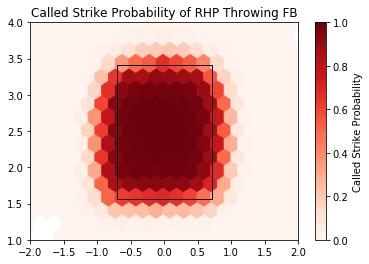

In [252]:
pitch_prob_plot('FB', 'R')

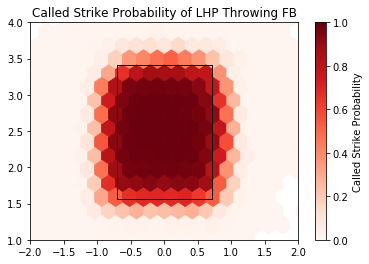

In [253]:
pitch_prob_plot('FB', 'L')

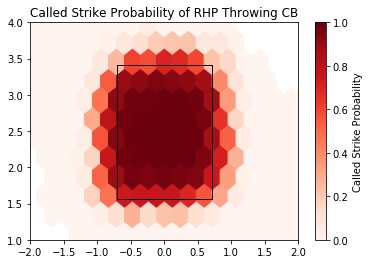

In [272]:
pitch_prob_plot('CB', 'R')

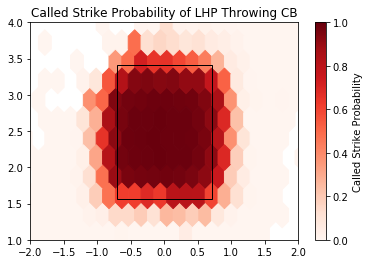

In [273]:
pitch_prob_plot('CB', 'L')